In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.modelbuilder.dfloader  import DataFrameLoader 
from mltools.modelwrappers.xgbwrapper import XgBoostWrapper
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
sns.set(style="darkgrid")
pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)

In [3]:
pkmn_type_colors = [
                    
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                    '#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    ]

In [4]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred


def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

def test_classifier(model,X,y,cv):
    clf = model.fit(X,y.values.ravel())
    result = clf.score(X,y.values)
    print ("Accuracy: {0:.3f}".format(result*100.0))

    train_sizes, train_scores, validation_scores = learning_curve(clf, X,y.values.ravel(),cv=cv)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return clf,result

In [5]:
load_app_config()
input_path = get_datafolder_path()
DIRECTORY ="noshowappointments"
TRAIN_FILE  = "KaggleV2-May-2016.csv"
train_file = os.path.join(input_path, DIRECTORY, TRAIN_FILE)

In [6]:
from datetime import datetime
datatypes = {'PatientId': np.float64, 'AppointmentID': np.int64, 'Gender': str, 'ScheduledDay': str,
             'AppointmentDay': str, 'Age': np.int32, 'Neighbourhood': str, 'Scholarship': np.int32, 'Hipertension': np.int32,
             'Diabetes': np.int32, 'Alcoholism': np.int32, 'Handcap': np.int32, 'SMS_received': np.int32,
             'No-show': str}
 

In [7]:
train_df = DataFrameLoader(train_file, dtype=datatypes,).dataframe

In [8]:
train_df['No-show'].replace('No', 0,inplace=True)
train_df['No-show'].replace('Yes', 1,inplace=True)
train_df['Gender'].replace('F', 0,inplace=True)
train_df['Gender'].replace('M', 1,inplace=True)
train_df.describe()

,PatientId,AppointmentID,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
count,1.1053e+05,1.1053e+05,110527.000,110527.0000,110527.0000,110527.0000,110527.0000,110527.0000,110527.0000,110527.0000,110527.0000
mean,1.4750e+14,5.6753e+06,0.350,37.0889,0.0983,0.1972,0.0719,0.0304,0.0222,0.3210,0.2019
std,2.5609e+14,7.1296e+04,0.477,23.1102,0.2977,0.3979,0.2583,0.1717,0.1615,0.4669,0.4014
min,3.9218e+04,5.0302e+06,0.000,-1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,4.1726e+12,5.6403e+06,0.000,18.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,3.1732e+13,5.6806e+06,0.000,37.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,9.4392e+13,5.7255e+06,1.000,55.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
max,9.9998e+14,5.7905e+06,1.000,115.0000,1.0000,1.0000,1.0000,1.0000,4.0000,1.0000,1.0000


In [9]:
def reassign_datatypes(data, columns, column_types):
    assert len(columns) == len(column_types)
    assert set(columns).issubset(data.columns.values)
    for column, column_type in zip(columns, column_types):
        data[column] = data[column].astype(column_type)
    return data

In [10]:
def add_datepart(df, fldname, drop=True, time=False, errors="raise"):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time:
        attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr:
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        if n.startswith('Is'):
            df[targ_pre + n] =df[targ_pre + n].astype(int)
            
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop:
        df.drop(fldname, axis=1, inplace=True)

In [11]:
train_df = reassign_datatypes(train_df, ['PatientId'], [np.int64])
train_df['ScheduledDay'] = pd.to_datetime(train_df['ScheduledDay'], format='%Y-%m-%dT%H:%M:%SZ')
train_df['AppointmentDay'] = pd.to_datetime(train_df['AppointmentDay'], format='%Y-%m-%dT%H:%M:%SZ')

In [12]:
train_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,0,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,558997776694438,5642503,1,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,4262962299951,5642549,0,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,867951213174,5642828,0,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,8841186448183,5642494,0,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0


##### Check any rows with all values missing
##### Check how many features have constant value , if any remove unique values  have no contribution in predictive models

In [13]:
from mltools.mlhelper import missing_values
training_missing_values = missing_values(train_df)
all_missing  = training_missing_values[training_missing_values['Missing_Values'] ==train_df.shape[0]]
print("No of columns that have 100% missing values :{0}".format(all_missing.shape[0]))
all_missing.head()


No of columns that have 100% missing values :0


,Feature,Missing_Values,Percent_of_Total_Values


In [14]:
add_datepart(train_df,'ScheduledDay',drop=False,time=True)

In [15]:
add_datepart(train_df,'AppointmentDay',drop=False,time=False)

In [16]:
train_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDayYear,ScheduledDayMonth,ScheduledDayWeek,ScheduledDayDay,ScheduledDayDayofweek,ScheduledDayDayofyear,ScheduledDayIs_month_end,ScheduledDayIs_month_start,ScheduledDayIs_quarter_end,ScheduledDayIs_quarter_start,ScheduledDayIs_year_end,ScheduledDayIs_year_start,ScheduledDayHour,ScheduledDayMinute,ScheduledDaySecond,ScheduledDayElapsed,AppointmentDayYear,AppointmentDayMonth,AppointmentDayWeek,AppointmentDayDay,AppointmentDayDayofweek,AppointmentDayDayofyear,AppointmentDayIs_month_end,AppointmentDayIs_month_start,AppointmentDayIs_quarter_end,AppointmentDayIs_quarter_start,AppointmentDayIs_year_end,AppointmentDayIs_year_start,AppointmentDayElapsed
0,29872499824296,5642903,0,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016,4,17,29,4,120,0,0,0,0,0,0,18,38,8,1461955088,2016,4,17,29,4,120,0,0,0,0,0,0,1461888000
1,558997776694438,5642503,1,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016,4,17,29,4,120,0,0,0,0,0,0,16,8,27,1461946107,2016,4,17,29,4,120,0,0,0,0,0,0,1461888000
2,4262962299951,5642549,0,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016,4,17,29,4,120,0,0,0,0,0,0,16,19,4,1461946744,2016,4,17,29,4,120,0,0,0,0,0,0,1461888000
3,867951213174,5642828,0,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016,4,17,29,4,120,0,0,0,0,0,0,17,29,31,1461950971,2016,4,17,29,4,120,0,0,0,0,0,0,1461888000
4,8841186448183,5642494,0,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016,4,17,29,4,120,0,0,0,0,0,0,16,7,23,1461946043,2016,4,17,29,4,120,0,0,0,0,0,0,1461888000


In [17]:
train_df['Handcap'] = train_df['Handcap'].astype(str)

In [18]:
train_df.drop(train_df[train_df['ScheduledDayYear']==2015].index,inplace=True)

In [19]:
patient_id_count = train_df.groupby(['PatientId', 'No-show'], as_index=False)['PatientId'].agg(['count'])
patient_id_count.rename(columns={'PatientId': 'count'}, inplace=True)

In [20]:
train_df.drop(train_df[train_df['Age'] ==-1].index,inplace=True)

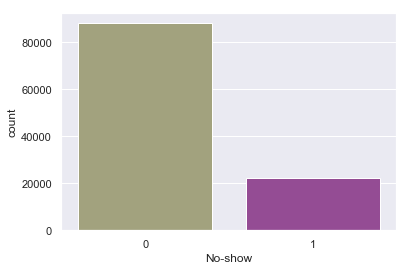

In [21]:
ax = sns.countplot(x="No-show", data=train_df,palette=pkmn_type_colors)

#####  As shown its a highly imbalanced dataset

In [22]:
feature_count  = train_df.nunique(dropna=False)
constant_features = pd.DataFrame({'feature':feature_count.index,'count':feature_count.values})
print("constant features :{0},{1}".format(*constant_features.shape))
constant_features[constant_features['count']==1] 

constant features :43,2


,feature,count
14,ScheduledDayYear,1
24,ScheduledDayIs_year_end,1
25,ScheduledDayIs_year_start,1
30,AppointmentDayYear,1
38,AppointmentDayIs_quarter_end,1
39,AppointmentDayIs_quarter_start,1
40,AppointmentDayIs_year_end,1
41,AppointmentDayIs_year_start,1


In [23]:
train_df.drop(constant_features[constant_features['count']==1]['feature'].values,axis =1,inplace=True)

In [24]:
continuous = ['Age']
columns_to_ignore =['PatientId','AppointmentID','Neighbourhood','No-show']
categorical = [column  for column in train_df.columns.values if column not in continuous+columns_to_ignore]


In [25]:
# f = pd.melt(train_df, value_vars=sorted(categorical[:12]))
# g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
# plt.xticks(rotation='vertical')
# g = g.map(sns.countplot, 'value')
# [plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
# g.fig.tight_layout()
# plt.show()

In [26]:
# f = pd.melt(train_df, value_vars=sorted(categorical[13:]))
# g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
# plt.xticks(rotation='vertical')
# g = g.map(sns.countplot, 'value')
# [plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
# g.fig.tight_layout()
# plt.show()

In [27]:
",".join(categorical)

'Gender,ScheduledDay,AppointmentDay,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,ScheduledDayMonth,ScheduledDayWeek,ScheduledDayDay,ScheduledDayDayofweek,ScheduledDayDayofyear,ScheduledDayIs_month_end,ScheduledDayIs_month_start,ScheduledDayIs_quarter_end,ScheduledDayIs_quarter_start,ScheduledDayHour,ScheduledDayMinute,ScheduledDaySecond,ScheduledDayElapsed,AppointmentDayMonth,AppointmentDayWeek,AppointmentDayDay,AppointmentDayDayofweek,AppointmentDayDayofyear,AppointmentDayIs_month_end,AppointmentDayIs_month_start,AppointmentDayElapsed'

In [28]:
# for column in ['ScheduledDayMonth','ScheduledDayWeek',]:
#     g=sns.factorplot("No-show", col = column, 
#                    data = train_df[train_df[column].notnull()],kind = "count",
#                    palette=pkmn_type_colors,size=5,aspect=1,col_wrap=4)
#     g.fig.get_axes()[0].set_yscale('log')
#     plt.show()

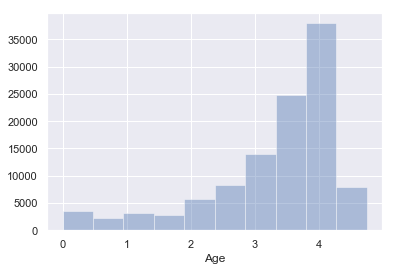

In [29]:
sns.distplot(np.log1p(train_df['Age']),bins=10, kde=False)

In [30]:
train_df['Age'] =np.log1p(train_df['Age'])

In [31]:
#bins =  list(np.linspace(0,100,11))
#display(bins)
#display(list(range(len(bins))))

#bins = list(np.linspace(0,100,11))
#labels = list(range(len(bins)-1))
#train_df['binned_Age'] = pd.cut(train_df['Age'], bins=bins, labels=labels)

In [32]:
#train_df['binned_Age'].fillna(0,inplace=True)
#train_df['binned_Age'] =train_df['binned_Age'].astype(str)

In [33]:
#categorical.append('binned_Age')
cat_data =  train_df[categorical+['No-show']]

In [34]:
# from scipy import stats
# def anova(frame,categorical_features):
#     anv = pd.DataFrame()
#     anv['features'] = categorical_features
#     pvals = []
#     for c in categorical_features:
#         samples = []
#         for cls in frame[c].unique():
#             s = frame[frame[c] == cls]['No-show'].values
#             samples.append(s)
#         pval = stats.f_oneway(*samples)[1]
#         pvals.append(pval)
#     anv['pval'] = pvals
#     return anv.sort_values('pval')

 
# k = anova(cat_data,categorical) 
# k['disparity'] = np.log(1./k['pval'].values) 

# plt.figure(figsize=(10,8))
# sns.barplot(data=k, x = 'features', y='disparity') 
# plt.xticks(rotation=90) 
# plt 

In [35]:
train_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDayMonth,ScheduledDayWeek,ScheduledDayDay,ScheduledDayDayofweek,ScheduledDayDayofyear,ScheduledDayIs_month_end,ScheduledDayIs_month_start,ScheduledDayIs_quarter_end,ScheduledDayIs_quarter_start,ScheduledDayHour,ScheduledDayMinute,ScheduledDaySecond,ScheduledDayElapsed,AppointmentDayMonth,AppointmentDayWeek,AppointmentDayDay,AppointmentDayDayofweek,AppointmentDayDayofyear,AppointmentDayIs_month_end,AppointmentDayIs_month_start,AppointmentDayElapsed
0,29872499824296,5642903,0,2016-04-29 18:38:08,2016-04-29,4.1431,JARDIM DA PENHA,0,1,0,0,0,0,0,4,17,29,4,120,0,0,0,0,18,38,8,1461955088,4,17,29,4,120,0,0,1461888000
1,558997776694438,5642503,1,2016-04-29 16:08:27,2016-04-29,4.0431,JARDIM DA PENHA,0,0,0,0,0,0,0,4,17,29,4,120,0,0,0,0,16,8,27,1461946107,4,17,29,4,120,0,0,1461888000
2,4262962299951,5642549,0,2016-04-29 16:19:04,2016-04-29,4.1431,MATA DA PRAIA,0,0,0,0,0,0,0,4,17,29,4,120,0,0,0,0,16,19,4,1461946744,4,17,29,4,120,0,0,1461888000
3,867951213174,5642828,0,2016-04-29 17:29:31,2016-04-29,2.1972,PONTAL DE CAMBURI,0,0,0,0,0,0,0,4,17,29,4,120,0,0,0,0,17,29,31,1461950971,4,17,29,4,120,0,0,1461888000
4,8841186448183,5642494,0,2016-04-29 16:07:23,2016-04-29,4.0431,JARDIM DA PENHA,0,1,1,0,0,0,0,4,17,29,4,120,0,0,0,0,16,7,23,1461946043,4,17,29,4,120,0,0,1461888000


In [36]:
train_df.drop(['PatientId','AppointmentID','Neighbourhood',],axis=1,inplace=True,)

In [37]:
train_df.drop(['ScheduledDay','AppointmentDay',],axis =1,inplace=True)

In [38]:
train_df.drop(['ScheduledDayDay','ScheduledDayHour',
               'ScheduledDayMonth','ScheduledDayWeek','ScheduledDayDayofweek',
               'ScheduledDayDayofyear' 
              ],axis =1,inplace=True)
train_df.drop(['ScheduledDayElapsed','AppointmentDayElapsed',
              'ScheduledDaySecond','ScheduledDayMinute','AppointmentDayDayofyear'
             ],axis=1,inplace=True)

In [39]:
y_train_df =train_df['No-show']
train_df.drop(['No-show'],axis =1,inplace=True)

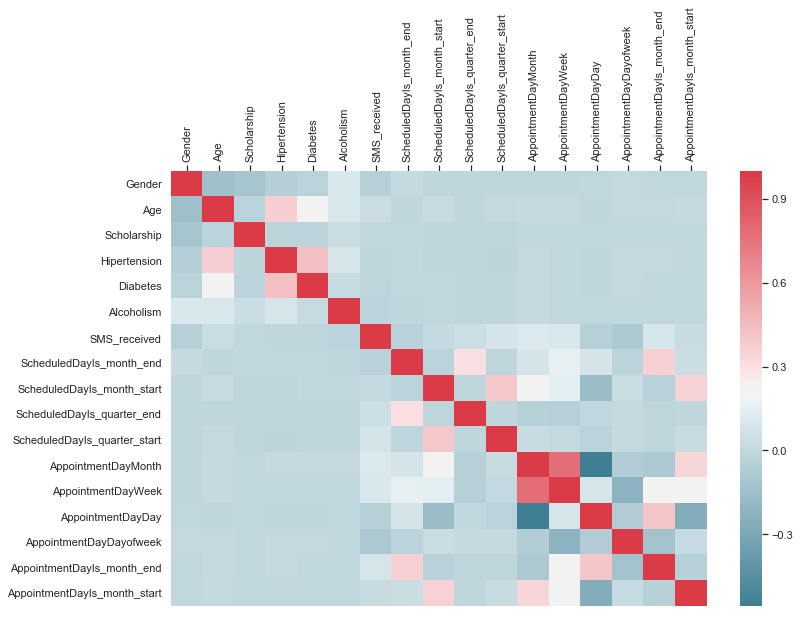

In [40]:
correlation = train_df[train_df.describe(include=[np.number]).columns.values.tolist()].corr()
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, 
           xticklabels=correlation.columns.values,
           yticklabels=correlation.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [41]:
full_dataset = pd.get_dummies(train_df, prefix_sep='_', drop_first=False)

In [42]:
full_dataset.drop(['Handcap_1'],axis=1,inplace=True)

In [43]:
y_train_df.head()

0    0
1    0
2    0
3    0
4    0
Name: No-show, dtype: int64

In [44]:
full_dataset.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,ScheduledDayIs_month_end,ScheduledDayIs_month_start,ScheduledDayIs_quarter_end,ScheduledDayIs_quarter_start,AppointmentDayMonth,AppointmentDayWeek,AppointmentDayDay,AppointmentDayDayofweek,AppointmentDayIs_month_end,AppointmentDayIs_month_start,Handcap_0,Handcap_2,Handcap_3,Handcap_4
0,0,4.1431,0,1,0,0,0,0,0,0,0,4,17,29,4,0,0,1,0,0,0
1,1,4.0431,0,0,0,0,0,0,0,0,0,4,17,29,4,0,0,1,0,0,0
2,0,4.1431,0,0,0,0,0,0,0,0,0,4,17,29,4,0,0,1,0,0,0
3,0,2.1972,0,0,0,0,0,0,0,0,0,4,17,29,4,0,0,1,0,0,0
4,0,4.0431,0,1,1,0,0,0,0,0,0,4,17,29,4,0,0,1,0,0,0


In [45]:
def evaluvate_model(clf ,X_trainmodel, y_trainmodel,X_val,y_val): 
    clf.fit(X_trainmodel, y_trainmodel.values.ravel())
    train_sizes, train_scores, validation_scores = learning_curve(clf, 
                                                                  X_trainmodel,y_trainmodel.values.ravel(),cv=kfold)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    plot_roc(X_val,y_val,clf)
    y_pred=measure_performance(X_val,y_val,clf, show_accuracy=False, 
                               show_classification_report=True,
                               show_confusion_matrix=True, show_r2_score=False)

In [46]:
from sklearn.model_selection import train_test_split
test_size = 0.30
seed = 42
X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(full_dataset, y_train_df, test_size=test_size,random_state=seed)
kfold = StratifiedKFold(n_splits=2)

In [47]:
display(full_dataset.shape)
display(X_trainmodel.shape)
display(X_val.shape)

(110464, 21)

(77324, 21)

(33140, 21)

In [48]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.feature_selection import SelectFromModel
# clf = ExtraTreesClassifier(random_state=42)
# selector = clf.fit(X_trainmodel, y_trainmodel)

# # plot most important features
# feat_imp = pd.Series(clf.feature_importances_, index = X_trainmodel.columns.values).sort_values(ascending=False)
# feat_imp[:40].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(12, 8))
# plt.ylabel('Feature Importance Score')
# plt.subplots_adjust(bottom=0.3)
# plt.savefig('1.png')
# plt.show()

# # clf.feature_importances_ 
# fs = SelectFromModel(selector, prefit=True)

# X_trainmodel = fs.transform(X_trainmodel)
# X_val = fs.transform(X_val)

[23:36:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:36:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:36:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:36:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:36:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:36:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:36:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:36:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:36:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

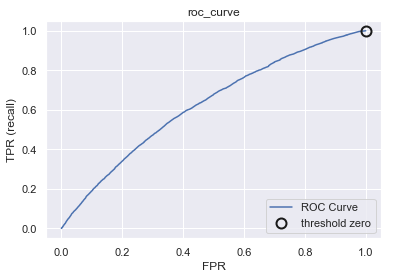

In [49]:
from xgboost.sklearn import XGBClassifier

xgbr = XGBClassifier(n_estimators=50, silent=False)
xgbr.fit(X_trainmodel ,y_trainmodel.values.ravel())
plot_roc(X_val,y_val,xgbr)

In [50]:
def calc_accuracy(predictions, y_test):
    labels = y_test.get_label()  
    return 'accuracy_score', (1 - sum(labels != predictions)/len(labels))

In [51]:
def calc_accuracy2(predictions, y_test):
    return 'accuracy_score', (1 - sum(y_test != predictions)/len(y_test))

In [52]:
import xgboost as xgb

In [53]:
xgb_params = {"objective": "multi:softmax",
          'num_class': 2,
          "booster" : "gbtree",
          'learning_rate': 0.1,
          "max_depth": 3,
          "subsample": 1,
          'colsample_bylevel': 0.8,
          'gamma': 0,
          'min_child_weight': 1.0,
          'alpha': 1,
          "silent": 1,
          'nrounds':20
          }

params_X = {
    "objective": "multi:softmax",
     'num_class': 2,
    'eta': 0.04,
    'max_depth': 5,
    'min_child_weight': 9.15,
    'gamma': 0.59,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 10.4,
    'lambda': 5,
    'nthread': 4,
    'silent': 1,
}
num_boost_round =15

In [54]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_trainmodel, y_trainmodel)
dvalid = xgb.DMatrix(X_val, y_val)
# 
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params_X, dtrain, num_boost_round, watchlist,feval=calc_accuracy,
                maximize=True, early_stopping_rounds=50, verbose_eval=True)

Train a XGBoost model
[0]	train-merror:0.201373	eval-merror:0.203048	train-accuracy_score:0.798627	eval-accuracy_score:0.796952
Multiple eval metrics have been passed: 'eval-accuracy_score' will be used for early stopping.

Will train until eval-accuracy_score hasn't improved in 50 rounds.
[1]	train-merror:0.201373	eval-merror:0.203048	train-accuracy_score:0.798627	eval-accuracy_score:0.796952
[2]	train-merror:0.201373	eval-merror:0.203048	train-accuracy_score:0.798627	eval-accuracy_score:0.796952
[3]	train-merror:0.201373	eval-merror:0.203048	train-accuracy_score:0.798627	eval-accuracy_score:0.796952
[4]	train-merror:0.201373	eval-merror:0.203048	train-accuracy_score:0.798627	eval-accuracy_score:0.796952
[5]	train-merror:0.201373	eval-merror:0.203048	train-accuracy_score:0.798627	eval-accuracy_score:0.796952
[6]	train-merror:0.201373	eval-merror:0.203048	train-accuracy_score:0.798627	eval-accuracy_score:0.796952
[7]	train-merror:0.201373	eval-merror:0.203048	train-accuracy_score:0.798

In [55]:
#xg = XgBoostWrapper(seed=27, params=xgb_params)
#xg.train(X_trainmodel, y_trainmodel)
#y_val_pred = xg.predict(X_val)
#calc_accuracy2(y_val_pred,y_val)

Text(0.5, 0, 'relative importance')

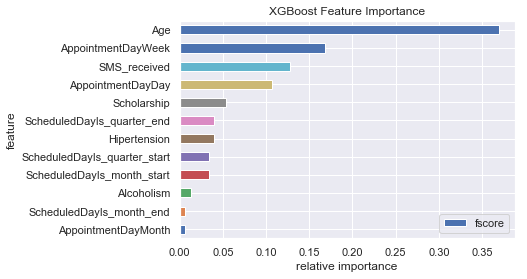

In [56]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

import operator
create_feature_map(X_trainmodel)

importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_importances = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_importances['fscore'] = df_importances['fscore'] / df_importances['fscore'].sum()

df_importances.plot(kind='barh', x='feature', y='fscore')
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [57]:
heatmap_data =X_trainmodel
corr_matrix =heatmap_data.corr('pearson')
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) 
correlation_threshold = 0.90
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold) and column not in ['SalePrice','LogSalePrice']]
to_drop    

[]

In [58]:
correlated_predictors ={}
record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])
for column in to_drop:
    co_related_features = list(upper.index[upper[column].abs() > correlation_threshold])
    co_related_values = list(upper[column][upper[column].abs() > correlation_threshold])
    drop_features = [column for _ in range(len(co_related_features))]  

    temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': co_related_features,
                                             'corr_value': co_related_values})
    record_collinear = record_collinear.append(temp_df, ignore_index = True)
record_collinear.sort_values(by=['corr_value'],ascending=True)

,drop_feature,corr_feature,corr_value
